In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.stats as sps

from collections import OrderedDict

In [2]:
import elfi

In [3]:
from abc_reconstruction.model import Model
from abc_reconstruction.utils import PriorPosition  #, cart_to_pol, pol_to_cart
from abc_reconstruction.prior import BoundedNormal_x, BoundedNormal_y

You don't have ROOT or root_pandas, root truth file output is disabled


# Init model

In [4]:
model = Model('XENON1T_ABC_all_pmts_on.ini')  #, coordinate_system = 'polar')

In [5]:
min_model = Model('XENON1T_ABC_all_pmts_on_minimal.ini')

In [6]:
model.change_defaults(s2_electrons = 25,)
min_model.change_defaults(s2_electrons = 25,)

In [7]:
model.hitpattern('full')  # 'full'
min_model.hitpattern('full')

In [8]:
model.output_timing = False
min_model.output_timing = False

In [9]:
prior_mean = PriorPosition()

In [10]:
true_pos = np.loadtxt('data/truepos_full.txt')

In [11]:
# Profiling test
#import cProfile

In [12]:
#cProfile.run('min_model(0,0)')  #, filename='profile_min_model00.cprof', sort='cumtime')

In [13]:
#%timeit -n 20 model(0,0)

In [14]:
#%timeit -n 20 min_model(0,0)

In [15]:
#model(0, 0, 25, 0)['energy'].shape

# Select pattern to reconstruct

In [17]:
# The true position of the hitpattern
#truth = np.array([30, 0])
truth = true_pos[0]
truth = np.array([2.62, -17.96])
print(truth)

[  2.62 -17.96]


In [18]:
true_z = 0
true_e = 25  # 25

In [19]:
#cart_to_pol(*true_pos[0])

In [20]:
# The hitpattern to reconstruct
#data = model(*cart_to_pol(*true_pos[0]))
data = model(*truth, true_e)  #, true_z)
# What pax thinks of this hitpattern
pax_pos = model.get_latest_pax_position()
# The prior mean (not used)
prior_pos = (pax_pos['PosRecTopPatternFit']['x'],
             pax_pos['PosRecTopPatternFit']['y'])  #prior_mean(data['energy']) 

In [21]:
prior_pos

(3.0002741228070136, -18.36167763157895)

In [22]:
def s2_to_e():
    # s2_electrons estimate
    s2 = model.output_plugin.last_event.main_s2
    #aft = s2.area_fraction_top # model.pax.simulator.config['s2_mean_area_fraction_top']
    #s2_area = s2.area_per_channel[127:248].sum() / (1 - aft)
    #assert np.isclose(s2_area, s2.area)
    s2_area = s2.area
    
    e_cor = s2.s2_bottom_spatial_correction * s2.s2_saturation_correction
    s2_secondary_sc_gain = model.pax.simulator.config['s2_secondary_sc_gain']  #  21.3 -> 23
    double_pe_prob = model.pax.simulator.config['p_double_pe_emision']  # 0.15
    pax_e = s2_area * e_cor / (s2_secondary_sc_gain * (1 + double_pe_prob))
    return pax_e

In [23]:
pax_e = s2_to_e()

In [24]:
pax_e

24.307566199781355

In [25]:
# Check that pax energy est centered on 25 here (using true pos for ly correction should yield better result, check)
# CHECKED: For positions 0,0 dist is centered on 25. Slightly lower values for true_pos positions, meaning LY maps not perfect.

In [26]:
# from tqdm import tqdm
# es = []
# for pos in tqdm(true_pos[0:200]):
#     _ = model(0, 0, 25)
#     es.append(s2_to_e())

In [27]:
# plt.hist(es, bins=20)
# plt.axvline(np.mean(es), color='red', linestyle='--')

# Build ELFI Priors

In [28]:
r_bound = 47.9 

In [29]:
prior_pos

(3.0002741228070136, -18.36167763157895)

In [30]:
# Custom Poisson Prior with 'pdf' method as workaround
from scipy.special import gamma

class PoissonPrior(elfi.Distribution):
    def rvs(mu, loc=0, size=1, random_state=None):
        return sps.poisson.rvs(mu=mu, loc=loc, size=size, random_state=random_state)
    
    def pdf(k, mu, loc=0):  # ELFI needs a 'pdf' function instead of pmf
        return mu**k * np.exp(-mu) / gamma(k + 1)

In [31]:
px = elfi.Prior(BoundedNormal_x, r_bound, prior_pos, 25)  # 25)
py = elfi.Prior(BoundedNormal_y, px, r_bound, prior_pos, 25)  # 25)
#pz = elfi.Prior('truncnorm', -96, 0, -20, 3)
mu = 25  #pax_e
std = 4  # mu**0.5
#pe = elfi.Prior('truncnorm', (10 - mu)/std, (90 - mu)/std, mu, std) # Offset 
#pe = elfi.Prior(PoissonPrior, mu)
#pe = elfi.Prior('gamma', pax_e)
#pe = elfi.Prior('norm', 25, 5)
#pe = elfi.Prior('weibull_min', 25, 0, 25)  # Offset
pe = elfi.Prior('lognorm', 0.1, 0, 25)  # pax_e)
#pe = elfi.Prior('uniform', 10, 90)

In [32]:
# x = np.linspace(15, 35, 100)
# y = sps.lognorm.pdf(x, s=0.1, scale=25)
# plt.plot(x, y)
# plt.axvline(25, color='red', linestyle='--')

## Get PMT mask

In [33]:
pmt_mask = model.pmt_mask[:248].astype(int)

In [34]:
pmt_mask

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

# Build BOLFI Model

In [35]:
min_model=elfi.tools.vectorize(min_model)

In [36]:
Y = elfi.Simulator(min_model, px, py, pe, observed=np.array([data]))

In [37]:
# Test calling FM
#elfi.Simulator.generate(Y)

In [38]:
def energy_distance(a, b):
    assert len(a) == len(b)
    return np.array([sps.energy_distance(a[i], b[i]) for i in range(len(a))])

In [39]:
def energy_sum(a, b):
    assert len(a) == len(b)
    v =  np.array([np.abs(np.sum(a[i]) + np.sum(b[i])) for i in range(len(a))])
    return v

## Define Distance functions

In [40]:
from scipy.spatial.distance import braycurtis

In [41]:
# def summarize(x, k):
#     return np.array([e[k] for e in x])
# 
# S1 = elfi.Summary(summarize, Y, 'energy')
# S2 = elfi.Summary(summarize, Y, 'time')

def energy_distance(a, b):                                              
    assert len(a) == len(b)                                             
    return np.array([sps.energy_distance(a[i], b[i]) for i in range(len(a))])

def bray_curtis(a, b):
    assert len(a) == len(b)
    return np.array([braycurtis(a[i][:127], b[i][:127]) for i in range(len(a))])

de = elfi.Distance(bray_curtis, Y)  # 'braycurtis', S1)
d2 = elfi.Distance(energy_distance, Y)  # 'braycurtis', S1)
#d3 = elfi.Distance('correlation', Y)  # 'braycurtis', S1)
#d4 = elfi.Distance('cosine', Y)  # 'braycurtis', S1)
#dt = elfi.Distance(energy_distance, Y)  # 'braycurtis', S2)

#de2 = elfi.Distance('braycurtis', S2)  # 'braycurtis', S1)
#dt2 = elfi.Distance(energy_distance, S1)  # 'braycurtis', S2)

#d = elfi.Operation(lambda a, b: a + b, de, dt)
d = elfi.Operation(lambda a, b: a + b, de, d2)

#d = elfi.Distance('braycurtis', Y)

In [42]:
#d = elfi.Distance('braycurtis', Y)  # , w=pmt_mask)
log_d = elfi.Operation(np.log, d)

# Distance cannot take weigths kwarg when passing callable instead of string, using functools instead
#log_d = elfi.Distance(likelihood_chisquare_masked, Y)

In [43]:
# Check Summary stat
#elfi.Simulator.generate(d)
#elfi.Simulator.generate(log_d)

In [44]:
# Load modified minimize function which we can pass different minimizer method and constraint.
from abc_reconstruction.utils import minimize, ConstraintLCBSC

In [45]:
from elfi.methods.bo.gpy_regression import GPyRegression
from elfi.methods.utils import ModelPrior

In [46]:
bounds = {'px':(-r_bound, r_bound),
          'py':(-r_bound, r_bound),
          #'pz':(-96, 0),
          'pe':(1, 90),
         } 

In [47]:
# To fix in ELFI, using discrete distributions in ModelPrior -> elfi.model.augmenter._add_distribution_nodes()
# For now workaround by using custom Prior

In [48]:
log_d.model.parameter_names

['pe', 'px', 'py']

In [49]:
# Define the default GP target model
target_model = GPyRegression(log_d.model.parameter_names, bounds=bounds)

# Define the custom acquisition method
acquisition_method = ConstraintLCBSC(target_model,
                                     prior = ModelPrior(log_d.model),
                                     noise_var = [5, 5, 5],  # 5, 5],
                                     exploration_rate = 10,
                                     #seed=self.seed  # Use np.random
                                    )
acquisition_method.d0 = log_d.model.parameter_names.index('px')  # Workaround for now, order of parameter_names is not always the same, set d0 and d1 to the x and y dimension (here 1 and 2)
acquisition_method.d1 = log_d.model.parameter_names.index('py')

In [50]:
target_model.bounds

[(1, 90), (-47.9, 47.9), (-47.9, 47.9)]

In [51]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=50, update_interval=1,
                   #bounds=bounds,  # Not used when using target_model
                   target_model = target_model,
                   acquisition_method = acquisition_method,
                   #acq_noise_var=[0.1, 0.1],  # Not used when using acquisition_method
                   #async=True,  # Could we use this?
                  )

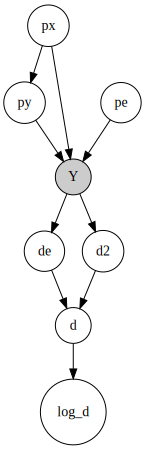

In [52]:
elfi.draw(px)

# Fit GP model

In [53]:
%time post = bolfi.fit(n_evidence=300)

CPU times: user 16min, sys: 23min 20s, total: 39min 21s
Wall time: 6min 14s


In [54]:
# Test animation
#for b in range(1, 200):
#bolfi.set_objective(n_evidence=200)  # b
#bolfi.iterate()  # Calls update()
#bolfi.plot_state()
#    plt.savefig('bolfi_surface_%03d.png' % b, dpi=150)
#bolfi.infer(n_evidence=100, vis=dict(xlim=(-r_bound, r_bound), ylim=(-r_bound, r_bound)))

In [55]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [56]:
plt.rc('font', size=16)

In [57]:
truth

array([  2.62, -17.96])

In [58]:
vals = [25] + list(truth)

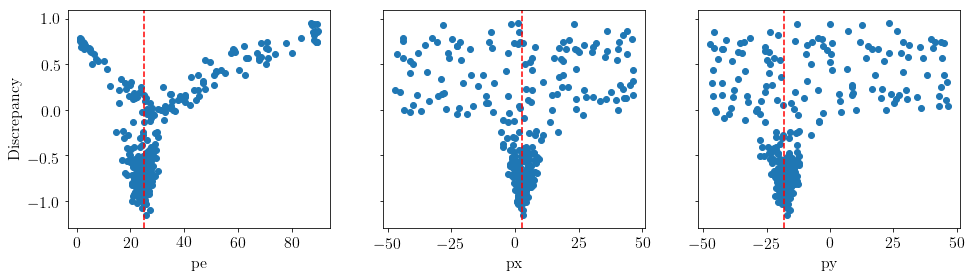

In [60]:
bolfi.plot_discrepancy()
for idx, ax in enumerate(plt.gcf().axes):
    ax.axvline(vals[idx], color='red', linestyle='--')
#plt.savefig('discrepancy_xye.png', dpi=150, bbox_inches='tight')

In [54]:
bolfi.target_model


Name : GP regression
Objective : -600.0328920805364
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |     0.6948994095579963  |      +ve      |  Ga(5.7, 1)
  sum.rbf.lengthscale      |      72.46137816881256  |      +ve      |  Ga(46, 1) 
  sum.bias.variance        |      4.601338043138659  |      +ve      |  Ga(1.4, 1)
  Gaussian_noise.variance  |  0.0006285107802945557  |      +ve      |            

In [55]:
def plot(dim_0 = 0, dim_1 = 1):
    samples = bolfi.target_model.X
    bounds = bolfi.target_model.bounds
    names = log_d.model.parameter_names

    plt.scatter(samples[:,dim_0], samples[:,dim_1], c=bolfi.target_model.Y.T[0])
    plt.colorbar()
    plt.xlim(bounds[dim_0])
    plt.ylim(bounds[dim_1])
    plt.xlabel(names[dim_0])
    plt.ylabel(names[dim_1])

In [56]:
bolfi.target_model.X.shape

(300, 3)

In [57]:
truth

array([-12.03792,  -6.37732])

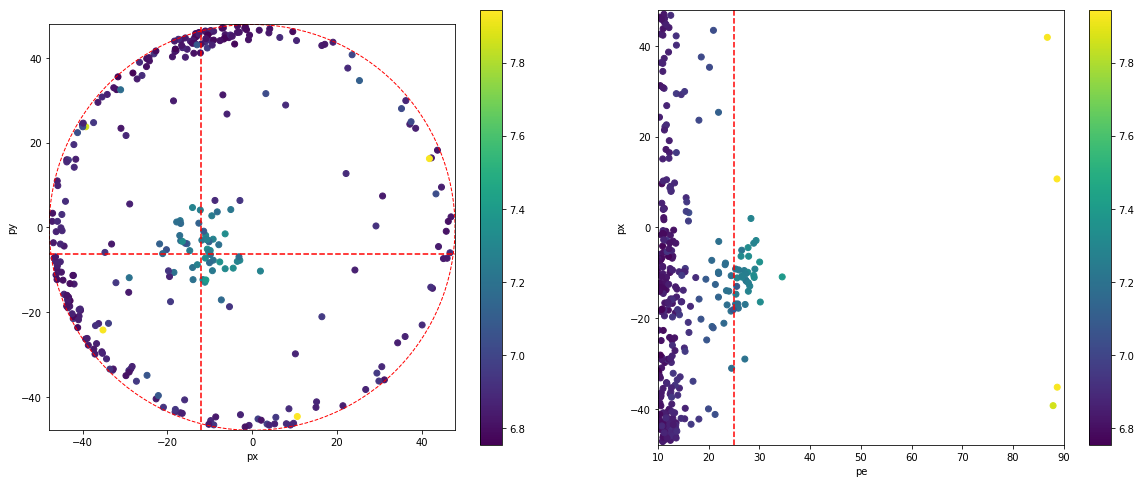

In [58]:
#plot(0, 1)  # e,x
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plot(1, 2)  # x,y
plt.gca().set_aspect(1)
plt.gca().add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
plt.axvline(truth[0], color='red', linestyle='--')
plt.axhline(truth[1], color='red', linestyle='--')

plt.subplot(1, 2, 2)
#plot(2, 3)  # y,z
plot(0, 1)
plt.axvline(25, color='red', linestyle='--')
#plt.gca().add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
plt.show()

In [57]:
points, discs = bolfi.target_model.X, bolfi.target_model.Y


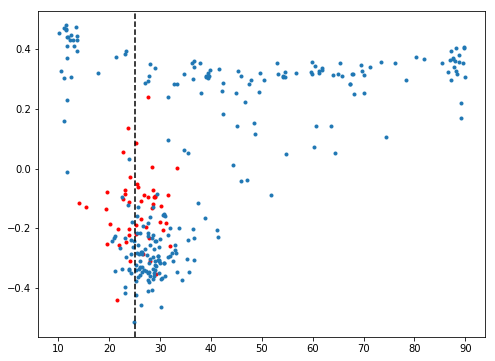

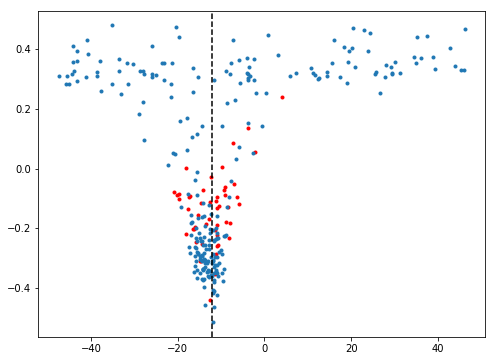

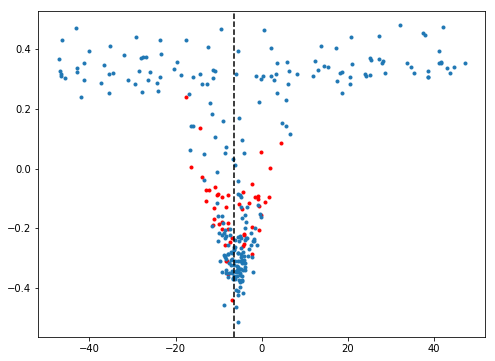

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(points.T[0][:50], discs.T[0][:50], '.', color='red')
plt.plot(points.T[0][50:], discs.T[0][50:], '.')
plt.axvline(25, color='k', linestyle='--')
#plt.axvline(pax_e, color='red', linestyle='--')
#plt.savefig("e_offset_uniform.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(points.T[1][:50], discs.T[0][:50], '.', color='red')
plt.plot(points.T[1][50:], discs.T[0][50:], '.')
plt.axvline(truth[0], color='k', linestyle='--')
#plt.axvline(pax_e, color='red', linestyle='--')
#plt.savefig("e_offset_uniform.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(points.T[2][:50], discs.T[0][:50], '.', color='red')
plt.plot(points.T[2][50:], discs.T[0][50:], '.')
plt.axvline(truth[1], color='k', linestyle='--')
#plt.axvline(pax_e, color='red', linestyle='--')
#plt.savefig("e_offset_uniform.png", dpi=150)
plt.show()

In [59]:
#bolfi.plot_state()
#plt.xlim(-50, 50)
#plt.ylim(-50, 50)
#for ax in plt.gcf().axes:
#    ax.add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
#plt.savefig('surface_constraint_edge_noise.png', dpi=150)
#plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f202dd78668>,
      dtype=object)

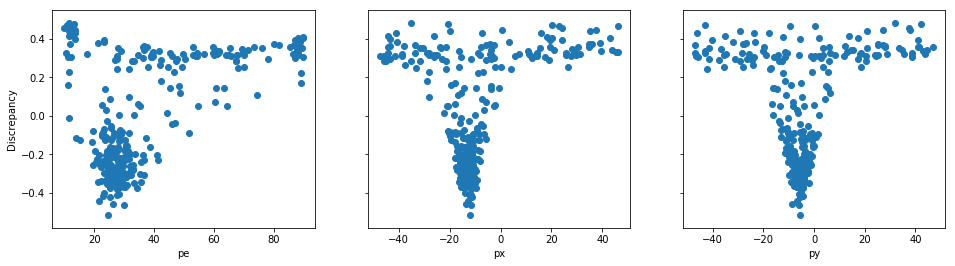

In [60]:
bolfi.plot_discrepancy()
#plt.savefig('test_xyze.png', dpi=150)

In [61]:
#post.plot(logpdf=True)  # Only for 2D

# Sample from GP model

In [62]:
#%time result_BOLFI = bolfi.sample(500, warmup=100, n_chains=8, info_freq=500)  # 500/100 23s, 1000/500 4 45s, 
%time result_BOLFI = bolfi.sample(1000, info_freq=100)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
pe 2155.981086189344 1.0016160862143766
px 3398.363694480551 1.000983927468641
py 3449.0544057768225 1.0021437353560911
CPU times: user 3min 24s, sys: 2min 25s, total: 5min 50s
Wall time: 1min 27s


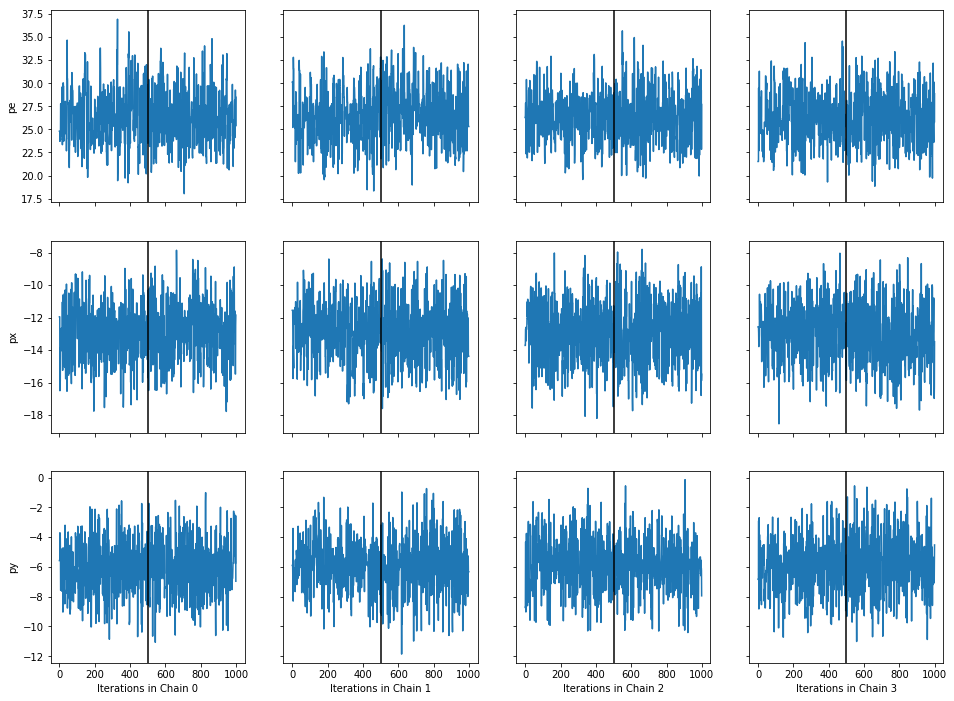

In [63]:
result_BOLFI.plot_traces();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f202dd1deb8>,
      dtype=object)

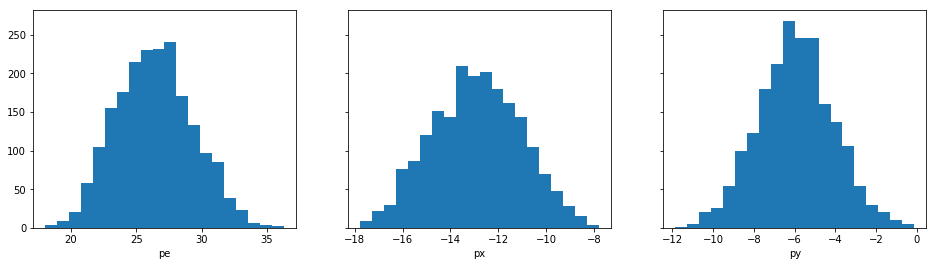

In [64]:
result_BOLFI.plot_marginals()

In [65]:
# true true_
# pax pax_e  d_e
# bolfi_mean_e d_e
# bolfi_median_e d_e
print('True energy: %d' % true_e)
print('pax energy: %.2f electrons,\t\t d_truth: %.2f' % (pax_e, np.abs(pax_e - true_e)))
print('BOLFI_mean energy: %.2f electrons,\t d_truth: %.2f' % (result_BOLFI.sample_means['pe'], np.abs(result_BOLFI.sample_means['pe'] - true_e)))
print('BOLFI_median energy: %.2f electrons,\t d_truth: %.2f' % (np.median(result_BOLFI.samples_array, axis=0)[0], np.abs(np.median(result_BOLFI.samples_array, axis=0)[0] - true_e)))



#print('mean z: %.2f cm,\t\t true z: %.2f' % (result_BOLFI.sample_means['pz'], true_z))

True energy: 25
pax energy: 22.48 electrons,		 d_truth: 2.52
BOLFI_mean energy: 26.41 electrons,	 d_truth: 1.41
BOLFI_median energy: 26.35 electrons,	 d_truth: 1.35


In [66]:
res = OrderedDict()
res['mean'] = [result_BOLFI.sample_means['px'], result_BOLFI.sample_means['py']]
res['median'] = bolfi_median = np.median(result_BOLFI.samples_array, axis=0)[1:]
res['mode'] = sps.mode(result_BOLFI.samples_array).mode[0][1:]
res['truth'] = truth
res['tpf'] = [pax_pos['PosRecTopPatternFit']['x'], pax_pos['PosRecTopPatternFit']['y']]
res['nn'] = [pax_pos['PosRecNeuralNet']['x'], pax_pos['PosRecNeuralNet']['y']]

for k, v in res.items():
    if k == 'truth':
        print('%s:\t x=%.2f cm,\t y=%.2f cm' % (k, v[0], v[1]))
    else:
        d = ((truth[0] - v[0])**2 + (truth[1] -  v[1])**2)**0.5
        print('%s:\t x=%.2f cm,\t y=%.2f cm,\t d_truth=%.2f cm' % (k, v[0], v[1], d))


mean:	 x=-12.90 cm,	 y=-5.94 cm,	 d_truth=0.97 cm
median:	 x=-12.87 cm,	 y=-5.97 cm,	 d_truth=0.93 cm
mode:	 x=-13.20 cm,	 y=-7.35 cm,	 d_truth=1.51 cm
truth:	 x=-12.04 cm,	 y=-6.38 cm
tpf:	 x=-12.36 cm,	 y=-6.60 cm,	 d_truth=0.39 cm
nn:	 x=-12.51 cm,	 y=-6.41 cm,	 d_truth=0.47 cm
